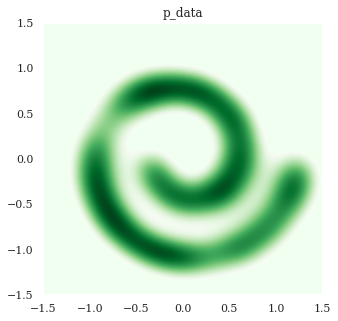

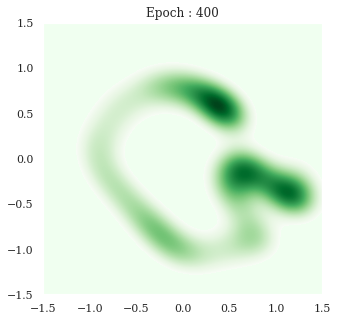

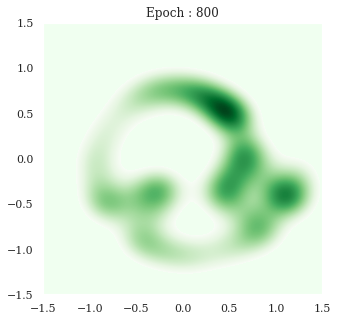

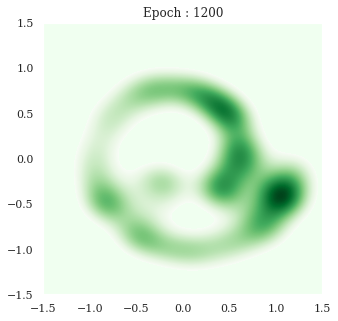

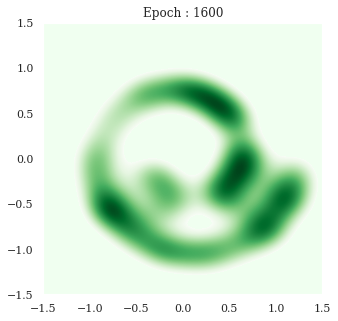

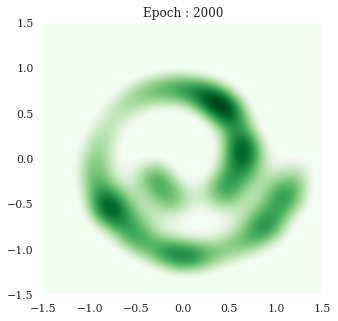

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.functional import leaky_relu
import torch.optim as optim

"""
Step 0 : Define training configurations
"""

batch_size = 64
learning_rate = 5e-4
num_epochs = 2000
reg_coeff = 150
enc_latent_dim = 128
dec_latent_dim = 64
device = "cuda:0" if torch.cuda.is_available() else "cpu"

"""
Step 1 : Define custom dataset 
"""

def make_swiss_roll(n_samples=2000, noise = 1.0, dimension = 2, a = 20, b = 5):
    """
    Generate 2D swiss roll dataset 
    """
    t = 2 * np.pi * np.sqrt(np.random.uniform(0.25,4,n_samples))
    
    X = 0.1 * t * np.cos(t)
    Y = 0.1 * t * np.sin(t)
    
    errors = 0.025 * np.random.multivariate_normal(np.zeros(2), np.eye(dimension), size = n_samples)
    X += errors[:, 0]
    Y += errors[:, 1]
    return np.stack((X, Y)).T

def show_data(data, title):
    """
    Plot the data distribution
    """
    sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
    plt.figure(figsize = (5, 5))
    plt.rc('text', usetex = False)
    plt.rc('font', family = 'serif')
    plt.rc('font', size = 10)
    
    g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")
    
    g.grid(False)
    plt.margins(0, 0)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.title(title)
    plt.show()


"""
Step 2 : Define custom dataset and dataloader. 
"""

class SwissRollDataset(Dataset) : 
    def __init__(self, data) : 
        super().__init__()
        self.data = torch.from_numpy(data)
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self, idx) :
        return self.data[idx]

    
data = make_swiss_roll()
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)


sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
plt.figure(figsize = (5, 5))
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('font', size = 10)

g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")

g.grid(False)
plt.margins(0, 0)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title('p_data')
plt.savefig('swiss_roll_true.png')
plt.show()


"""
Step 3 : Implement models
"""
class Encoder(nn.Module):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    self.fc1 = nn.Linear(2, latent_dim)
    self.fc2 = nn.Linear(latent_dim, latent_dim)
    self.fc3 = nn.Linear(latent_dim, 2)

  def forward(self, input):
    z = input.view(input.size(0), -1)
    z = self.fc1(z)
    z = leaky_relu(z, 0.2)
    z = self.fc2(z)
    z = torch.tanh(z)
    z = self.fc3(z)
    mu = z[:,:1]
    log_std = z[:,1:]
    return mu, log_std

class Decoder(nn.Module):
  def __init__(self, latent_dim):
    super(Decoder, self).__init__()
    self.fc1 = nn.Linear(1, latent_dim)
    self.fc2 = nn.Linear(latent_dim, latent_dim)
    self.fc3 = nn.Linear(latent_dim, 2)

  def forward(self, input):
    z = self.fc1(input)
    z = leaky_relu(z, 0.2)
    z = self.fc2(z)
    z = torch.tanh(z)
    output = self.fc3(z)
    return output


"""
Step 4 : Train models
""" 
Encoder = Encoder(enc_latent_dim).to(device)
Decoder = Decoder(dec_latent_dim).to(device)
optimizer = optim.Adam(list(Encoder.parameters()) + list(Decoder.parameters()), lr=learning_rate)


# log_p_theta_(z|x) (reconstruction loss)
def log_p(x_hat, x):
    mse = nn.MSELoss().to(device)
    return -mse(x_hat, x)

# reparametrization trick
def reparametrization_trick(mu, log_std):
    z = torch.randn_like(mu)*log_std.exp()+mu
    return z

def kl_div(mu, log_std):
    kl = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
    kl = kl.sum(1).mean()
    return kl





for epoch in range(num_epochs) : 
    for batch_idx, x in enumerate(loader) : 
        x = x.to(device).float()
        mu, log_std = Encoder(x)
        z = reparametrization_trick(mu, log_std)
        x_hat = Decoder(z)

        recon_loss = -log_p(x_hat, x)
        regularizer = kl_div(mu, log_std)

        loss = recon_loss* reg_coeff + regularizer

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # Visualize the intermediate result
    if epoch % (num_epochs // 5) == (num_epochs//5 - 1):
        
        z = torch.randn(2000, 1).to(device)
        data = Decoder(z).to("cpu").detach()
        show_data(data, f"Epoch : {epoch+1}")
        
